# Import Modules

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from loguru import logger
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, PreTrainedTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import wandb

tqdm.pandas()


/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Prepare Dataset

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/openj9_processed.csv"

df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]

def clean_issue_description(text):
    cleaned_text = text.strip()
    cleaned_text = re.sub(r'0x[\da-fA-F]+', '<HEX>', cleaned_text)
    cleaned_text = re.sub(r'\b[0-9a-fA-F]{16}\b', '<HEX>', cleaned_text)
    cleaned_text = re.sub(r'\b\d{2}:\d{2}:\d{2}\.\d{3}\b', '<TIMESTAMP>', cleaned_text)
    cleaned_text = re.sub(r'\s*[-+]?\d*\.\d+([eE][-+]?\d+)?', '<FLOAT_VALUE>', cleaned_text)
    cleaned_text = re.sub(r'=\s*-?\d+', '= <PARAM_VALUE>', cleaned_text)
    
    return cleaned_text

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)
    df["text"] = df["text"].apply(clean_issue_description)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.progress_apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nComponent: "
            + str(x["component"])
            + "\nIssue Topic: "
            + str(x["topic_label"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)
df = df.sort_values(by="issue_number")

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

100%|██████████| 4381/4381 [00:00<00:00, 76708.63it/s]


Total number of issues: 4381


In [3]:
df.head()

,Unnamed: 0,issue_number,issue_title,description,issue_url,issue_state,creator,labels,owner,component,text,topic_id,topic_probs,topic_label
0,0,2,Build instructions link in the README.md point...,The `Build instructions` link in the `README.m...,https://github.com/eclipse-openj9/openj9/issues/2,closed,aarongraham9,NaN,mstoodle,NaN,Title: Build instructions link in the README.m...,6,"[0.059013333171606064, 0.03259052336215973, 0....",Build issues with OpenJ9
1,1,3,FAQ link in the README is broken,FAQ link in the README leads to: http://www.ec...,https://github.com/eclipse-openj9/openj9/issues/3,closed,dorrab,NaN,mstoodle,NaN,Title: FAQ link in the README is broken \nComp...,6,"[0.07123944908380508, 0.040990862995386124, 0....",Build issues with OpenJ9
2,2,5,Link to DockerFile on build instruction page i...,Link for DockerFile on [build instruction page...,https://github.com/eclipse-openj9/openj9/issues/5,closed,r30shah,NaN,anikser,NaN,Title: Link to DockerFile on build instruction...,4,"[0.048622023314237595, 0.047142378985881805, 0...",Jenkins automation
3,3,11,HOWTO Request: Managing changes across depende...,"Like all projects, OpenJ9 builds on the should...",https://github.com/eclipse-openj9/openj9/issue...,open,mgaudet,question,MarkQingGuo,NaN,Title: HOWTO Request: Managing changes across ...,4,"[0.1822623461484909, 0.0, 0.0, 0.0, 0.38227498...",Jenkins automation
4,4,13,Compilation Output is too Verbose,The output when compiling the OpenJ9 source co...,https://github.com/eclipse-openj9/openj9/issue...,closed,rservant,"enhancement, comp:build",MarkQingGuo,comp:build,Title: Compilation Output is too Verbose\nComp...,8,"[0.0273155365139246, 0.0460672564804554, 0.074...",JITServer AOT Cache Optimization


In [4]:
df["topic_hot"] = pd.get_dummies(df["topic_label"]).values.tolist()


In [5]:
vm_users = ['pshipton', 'keithc-ca', 'gacholio', 'tajila', 'babsingh', 'JasonFengJ9', 'fengxue-IS', 'hangshao0', 'theresa.t.mammarella', 'ChengJin01', 'singh264', 'thallium', 'ThanHenderson']
jvmti_users = ['gacholio', 'tajila', 'babsingh', 'fengxue-IS']
jclextensions_users = ['JasonFengJ9', 'pshipton', 'keithc-ca']
test_users = ['LongyuZhang', 'annaibm', 'sophiaxu0424', 'KapilPowar', 'llxia']
build_users = ['adambrousseau', 'mahdipub']
gc_users = ['dmitripivkine', 'amicic', 'kangyining', 'LinHu2016']

# Putting them in dictionaries
components = {
    'comp:vm': vm_users,
    'comp:jvmti': jvmti_users,
    'comp:jclextensions': jclextensions_users,
    'comp:test': test_users,
    'comp:build': build_users,
    'comp:gc': gc_users
}

expected_users = [user for user_list in components.values() for user in user_list]

In [6]:
df = df[df["owner"].isin(expected_users)]
print("Total issues after developer filtering:", len(df))

Total issues after developer filtering: 2068


In [7]:
df.owner.value_counts()

owner
JasonFengJ9      393
pshipton         379
keithc-ca        275
babsingh         221
hangshao0        123
ChengJin01       117
gacholio         109
fengxue-IS       107
llxia             98
tajila            79
dmitripivkine     33
LongyuZhang       33
LinHu2016         30
amicic            19
singh264          19
thallium          15
ThanHenderson     12
kangyining         5
sophiaxu0424       1
Name: count, dtype: int64

In [8]:
# Cross-Validation Fold Definition

num_cv = 10
sample_threshold = 10 # Threshold to filter developers
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 9 
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 207


In [9]:
# Train and Validation preparation

X_df = sliced_df[:samples_per_block*block]
y_df = sliced_df[samples_per_block*block : samples_per_block * (block+1)]

developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.owner.unique())}")

Training data: 1843, Validation data: 188
Number of developers: 15


<Axes: xlabel='owner'>

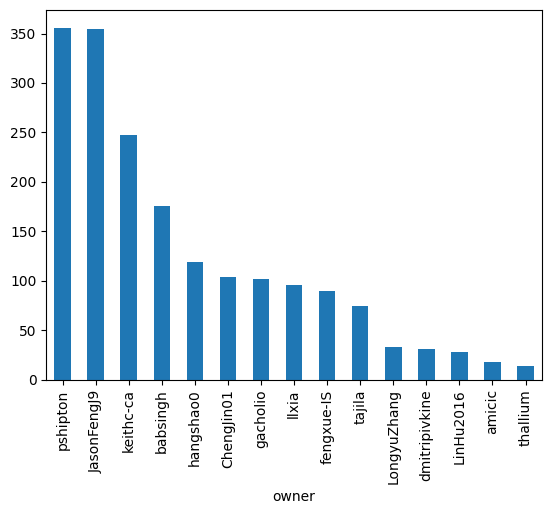

In [10]:
X_df.owner.value_counts().plot(kind="bar")

In [11]:
# Label encode developers

lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

<Axes: xlabel='owner_id'>

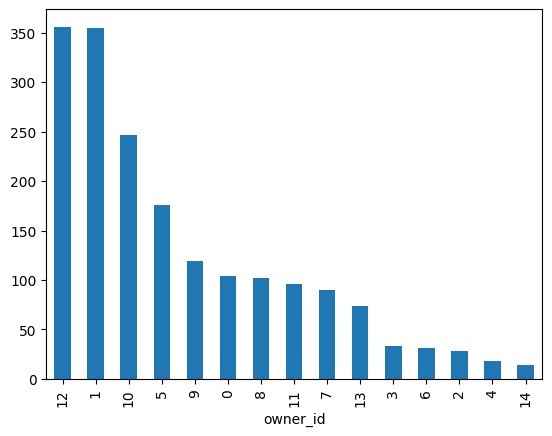

In [12]:
# Contribution plot

X_df.owner_id.value_counts().plot(kind="bar")

# Prepare PyTorch Dataset

In [13]:
class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ), torch.tensor([float(x.strip()) for x in row.topic_probs[1:-1].split(",")]))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


# Modified Transformer Model

In [14]:
from transformers import DebertaModel, DebertaConfig

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [15]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, topic_size, unfrozen_layers=4, embed_size=1024, dropout=0.1, lstm_hidden_size=128
    ) -> None:
        super().__init__()
        model_name = "microsoft/deberta-large"
        self.base_model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, self.base_model.config.num_hidden_layers - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.bilstm = nn.LSTM(embed_size, lstm_hidden_size, batch_first=True, bidirectional=True)

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + lstm_hidden_size * 2 + topic_size, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, tok_type, topic_id):
        outputs = []

        base_out = self.base_model(input_ids=input_ids, token_type_ids=tok_type, attention_mask=attention_mask)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]
        # print(base_out.last_hidden_state.shape)
        # print(base_out.last_hidden_state)
        last_hidden_state = base_out.last_hidden_state

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x_cnn = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            # Concatenate the outputs of the CNN
            x_cnn = torch.cat(x_cnn, dim=1)
            x_cnn = self.dropout(x_cnn)

            # Obtain the output of BiLSTM
            x_lstm, _ = self.bilstm(last_hidden_state[:, 0, :])

            # print(x_lstm.shape)
            # print(x_cnn.shape)

            # Concatenate the output of BiLSTM with the output of CNN
            x = torch.cat([x_cnn, x_lstm], dim=1)
            x = torch.cat([x, topic_id], dim=1)
            x = self.dropout(x)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs
    
    def tokenizer(self) -> AutoTokenizer:
        return self._tokenizer


# Loss Functions

In [16]:
class CombineLoss(nn.Module):
    def __init__(self, weights = None) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss(weight=weights)
    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)

        return loss

# Training Parameters

In [17]:
num_classes = len(X_df["owner_id"].unique())
print(num_classes)

15


In [18]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


True

In [19]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() # corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
weights_save_location = f"openj9_bilstm-cnn_{block}.pt"

# Define hyperparameters
learning_rate = 1e-4
epochs = 20
batch_size = 15

model = LBTPClassifierTopic(len(X_df.owner_id.unique()), 20, dropout=0.3)
criterion = CombineLoss(weights=None)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-8)

In [20]:
wandb.init(
    # Set the project where this run will be logged
    project="openj9_developers", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"developer_prediction_topicprobs_bilstm-cnn_{num_classes}_classes", 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "Deberta-LBT-P",
    "dataset": "openj9",
    "epochs": epochs,
})

In [21]:
# Prepare torch dataset from train and validation splits
train = TriageDataset(X_df, model.tokenizer())
val = TriageDataset(y_df, model.tokenizer())

2024-04-26 16:23:00.766 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-04-26 16:23:00.770 | DEBUG    | __main__:__init__:13 - Tokenizing texts...
2024-04-26 16:23:05.143 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-04-26 16:23:05.146 | DEBUG    | __main__:__init__:13 - Tokenizing texts...


In [22]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=10,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=10)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-04-26 16:23:05.841 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [24]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top K: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"
        
        wandb.log({
            "train_acc": total_acc_train / len(train_data), 
            "train_loss": total_loss_train / len(train_data),
            "val_acc": total_acc_val / len(validation_data),
            "val_loss": total_loss_val / len(validation_data),
            "top3_acc": topk,
            "precision": precision,
            "recall": recall,
            "f1-score": f1_score
        })

        logger.info(log)

# Training Loop

In [25]:
model = model.cuda()

In [26]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader, desc="Training Steps"):
        # print(train_input)
        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = train_input[2].to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type, repr)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in tqdm(val_dataloader, desc="Validation Steps"):
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
            repr = val_input[2].to(device)

            output = model(input_id, mask, tok_type, repr)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(3, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    topk = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        topk,
    )

    val_loss = total_loss_val / len(y_df)

    if scheduler:
        scheduler.step(val_loss)

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), weights_save_location)
        best_loss = val_loss

Validation Steps: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-04-26 16:26:04.959 | INFO     | __main__:log_step:34 - Epochs: 1 | Train Loss:  0.999                     | Train Accuracy:  0.363                     | Val Loss:  1.159                     | Val Accuracy:  0.181                     | Top K: 0

: 

# Evaluation

In [ ]:
# Load best checkpoint
model.load_state_dict(torch.load(weights_save_location))

<All keys matched successfully>

In [ ]:
loader = DataLoader(val, 30)

In [ ]:
# Load embeddings for all train data
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
all_embeddings = similarity_model.encode(X_df.issue_title.to_list(), batch_size=15)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
def get_top_k_similar_devs(issues, k=5, threshold=0.7):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk_values, topk_indices = torch.topk(cos, k=k)
    
    similarities = []
    
    for idx, sim_score in zip(topk_indices, topk_values):
        sim_threshold = sim_score >= threshold
        filtered_idx = idx[sim_threshold].numpy()
        similarities.append(X_df.iloc[filtered_idx]["owner_id"].unique().tolist())

    return similarities

In [ ]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = val_input[2].to(device)

        output = model(input_id, mask, tok_type, repr)



        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(10, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        _, top_k_predictions = output.topk(10, 1, True, True)
        similar_preds = get_top_k_similar_devs(val_input[0], threshold=0.65)

        unique_preds = []

        for top, sim in zip(top_k_predictions, similar_preds):
            # print(top, sim)
            
            copy_pred = top.cpu().numpy().tolist()
            top_preds = top.cpu().numpy().tolist()[:5]

            for s in sim:
                if s not in top_preds:
                    top_preds.append(s)
            
            if len(top_preds) < 10:
                top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
            unique_preds.append(top_preds)

        unique_preds = torch.tensor(unique_preds).cuda()
        top_k_predictions = unique_preds.t()

        correct_top_k += (
            top_k_predictions.eq(
                val_label.view(1, -1).expand_as(top_k_predictions)
            )
            .sum()
            .item()
        )

        # break

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

In [ ]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
print(f"Correct Prediction with Similarity: {correct_top_k}, {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 174, 0.925531914893617
Correct Prediction with Similarity: 173, 0.9202127659574468


In [ ]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

# Result Analysis

In [ ]:
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

ValueError: Number of classes, 15, does not match size of target_names, 1843. Try specifying the labels parameter

In [ ]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [ ]:
def get_topic_distribution(owner):
    print("Training topic distribution")
    print("=======================================")
    print(X_df[X_df.owner == owner].topic_label.value_counts())

    print("\n\nTesting topic distribution")
    print("=======================================")
    print(y_df[y_df.owner == owner].topic_label.value_counts())

In [ ]:
X_df.topic_label.value_counts()

Chrome Tab and Window Behavior Issues     947
Build failures                            840
Chrome stability issues                   487
Layout Testing Issues                     400
Chrome crash reports                      391
Security and SSL issues                   372
Input and keyboard issues                 370
Webpage rendering regression issues       357
Chrome sync issues                        354
Shill WiFi configuration                  337
iOS File Issues                           321
Data Enhancement                          298
Touch and Scroll Issues                   273
DevTools Crashes                          260
GPU rendering issues                      235
Memory Leaks in WebCore and Blink         220
Performance testing issues in Chromium    197
WebRTC audio/video issues                 184
Bookmark issues                           174
Performance Regression in Blink            13
Name: topic_label, dtype: int64

In [ ]:
get_topic_distribution("a...@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     10
Webpage rendering regression issues        5
Memory Leaks in WebCore and Blink          4
Chrome stability issues                    4
DevTools Crashes                           3
Data Enhancement                           3
Input and keyboard issues                  3
Touch and Scroll Issues                    2
Bookmark issues                            1
Security and SSL issues                    1
Chrome sync issues                         1
Layout Testing Issues                      1
Build failures                             1
iOS File Issues                            1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues     17
Webpage rendering regression issues        7
DevTools Crashes                           6
iOS File Issues                            6
Touch and Scroll Issues                    4
Input and k